In [1]:
import pandas as pd
undebate = pd.read_csv(r"C:\Users\Swapnil Mishra\Desktop\DS\Text Mining\Topic Modeling-LDA\undebate1.csv")

In [2]:
undebate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2507 entries, 0 to 2506
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            2507 non-null   int64 
 1   session               2507 non-null   int64 
 2   year                  2507 non-null   int64 
 3   country               2507 non-null   object
 4   text                  2507 non-null   object
 5   paragraphs            2507 non-null   object
 6   number_of_paragraphs  2507 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 137.2+ KB


In [3]:
print(repr(undebate.iloc[666]["text"][0:200])) #repr a printable representation of an object

'\nMay I express my gratitude for the honour of representing\nfor the first time, as Head of State, the independent country\nof Uzbekistan at the United Nations General Assembly.\nWe see the United Nations'


In [4]:
print(repr(undebate.iloc[729]["text"][0:200]))

'\ufeff179.\t It is with great pleasure that I extend to Mr. Lazar Mojsov, the representative of Yugoslavia, my heartfelt congratulations and best wishes on his election as President of this session of the G'


In [5]:
import re
undebate["paragraphs"] = undebate["text"].map(lambda text: re.split('[.?!]\\s*\n', text)) # split at full stops, exclamation points and question marks
undebate["number_of_paragraphs"] = undebate["paragraphs"].map(len)

<Axes: xlabel='year'>

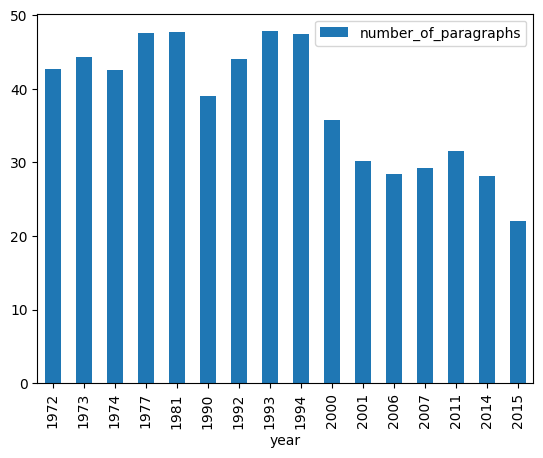

In [6]:
%matplotlib inline
undebate.groupby('year').agg({'number_of_paragraphs': 'mean'}).plot.bar()

In [7]:
# pip install pydantic==1.10.9

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

In [9]:
tfidf_text = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)  
vectors_text = tfidf_text.fit_transform(undebate['text'])
print(vectors_text.shape)

C:\Users\Swapnil Mishra\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(2507, 16798)


In [10]:
# flatten the paragraphs keeping the years
paragraph_df = pd.DataFrame([{ "text": paragraph, "year": year } 
                               for paragraphs, year in \
                               zip(undebate["paragraphs"], undebate["year"]) 
                                    for paragraph in paragraphs if paragraph])

In [11]:
tfidf_para_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_para_vectors = tfidf_para_vectorizer.fit_transform(paragraph_df["text"])
print(tfidf_para_vectors.shape)

(92741, 17253)


In [12]:
from sklearn.feature_extraction.text import CountVectorizer

# Ensure stopwords is a list
count_para_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(paragraph_df["text"])
print(count_para_vectors.shape)


(92741, 17253)


In [13]:
from sklearn.decomposition import LatentDirichletAllocation

lda_para_model = LatentDirichletAllocation(n_components = 10, random_state = 42)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors) # Documents vs topics
H_lda_para_matrix = lda_para_model.components_   # words vs topics

In [14]:
W_lda_para_matrix

array([[0.00400003, 0.00400002, 0.00400002, ..., 0.00400004, 0.00400008,
        0.00400008],
       [0.14106928, 0.00208414, 0.0020838 , ..., 0.00208368, 0.10540669,
        0.00208395],
       [0.39317799, 0.00238143, 0.00238183, ..., 0.00238185, 0.30600534,
        0.00238165],
       ...,
       [0.00312526, 0.38466046, 0.43089508, ..., 0.00312603, 0.00312527,
        0.00312554],
       [0.00769446, 0.67955949, 0.00769328, ..., 0.00769475, 0.00769468,
        0.25888728],
       [0.00322631, 0.62602042, 0.00322612, ..., 0.00322645, 0.00322628,
        0.00322714]])

In [15]:
H_lda_para_matrix

array([[2.15837800e+01, 1.00008145e-01, 1.00009675e-01, ...,
        2.09977939e+00, 1.00002046e-01, 1.00019159e-01],
       [1.00006784e-01, 1.00004667e-01, 1.00003665e-01, ...,
        1.00013419e-01, 1.00001862e-01, 1.09420370e+01],
       [3.91114854e+02, 1.00006460e-01, 1.00005814e-01, ...,
        1.00000000e-01, 1.00101070e-01, 1.00018234e-01],
       ...,
       [1.09924737e-01, 1.00000714e-01, 1.00001398e-01, ...,
        1.00090502e-01, 1.00005809e-01, 1.00008277e-01],
       [1.36766378e+02, 1.00006273e-01, 1.00004623e-01, ...,
        1.00118915e-01, 1.00004834e-01, 1.00016730e-01],
       [9.63326840e-01, 9.40999567e+01, 8.00999566e+01, ...,
        1.00252013e-01, 1.00007865e-01, 2.19236130e+00]])

In [16]:
def display_topics(model, features, no_top_words = 5):
    for topic, word_vector in enumerate(model.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]],
                  word_vector[largest[i]]*100.0/total))

In [17]:
#pip install spacy

C:\Users\Swapnil Mishra\AppData\Roaming\Python\Python39\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


TFIDF Shape: (92741, 17253)

Topic 00
  nuclear (2.33)
  weapons (1.75)
  international (1.37)
  disarmament (1.29)
  states (1.06)

Topic 01
  international (2.07)
  human (2.06)
  rights (1.99)
  peace (1.83)
  world (1.52)

Topic 02
  countries (3.45)
  economic (2.35)
  development (2.33)
  developing (1.64)
  world (1.52)

Topic 03
  peace (1.59)
  east (1.54)
  israel (1.41)
  middle (1.40)
  security (1.37)

Topic 04
  government (2.83)
  people (2.62)
  country (2.38)
  national (1.36)
  democratic (1.16)

Topic 05
  world (1.76)
  africa (1.55)
  people (1.29)
  south (1.01)
  war (0.95)

Topic 06
  general (3.68)
  nations (3.40)
  united (3.26)
  assembly (2.61)
  session (2.22)

Topic 07
  international (2.32)
  countries (1.37)
  nations (1.12)
  problems (1.12)
  world (0.94)

Topic 08
  united (4.62)
  nations (3.77)
  states (1.86)
  council (1.46)
  republic (1.43)

Topic 09
  peace (2.09)
  conflict (1.05)
  united (1.03)
  efforts (1.01)
  international (1.00)


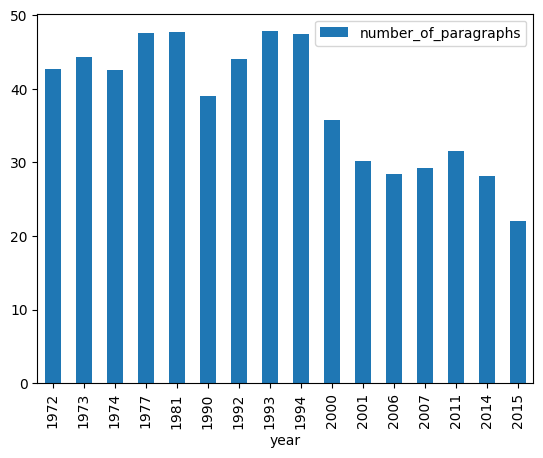

In [18]:
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

# Ensure stopwords is a list
stopwords = list(stopwords)

# Preprocess the undebate DataFrame
undebate["paragraphs"] = undebate["text"].fillna("").map(lambda text: re.split(r'[.?!]\s*\n', text))
undebate["number_of_paragraphs"] = undebate["paragraphs"].map(len)

# Plot number of paragraphs by year
undebate.groupby('year').agg({'number_of_paragraphs': 'mean'}).plot.bar()

# Create paragraph DataFrame
paragraph_df = pd.DataFrame([{ "text": paragraph, "year": year } 
                             for paragraphs, year in \
                             zip(undebate["paragraphs"].dropna(), undebate["year"].dropna()) 
                             for paragraph in paragraphs if paragraph])

# Initialize TfidfVectorizer
tfidf_para_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_para_vectors = tfidf_para_vectorizer.fit_transform(paragraph_df["text"])
print("TFIDF Shape:", tfidf_para_vectors.shape)

# Initialize CountVectorizer
count_para_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(paragraph_df["text"])

# Apply LDA
lda_para_model = LatentDirichletAllocation(n_components=10, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

# Display Topics
def display_topics(model, features, no_top_words=5):
    for topic, word_vector in enumerate(model.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1]  # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], word_vector[largest[i]] * 100.0 / total))

display_topics(lda_para_model, count_para_vectorizer.get_feature_names_out())

In [26]:
import pyLDAvis.sklearn

lda_display = pyLDAvis.sklearn.prepare(lda_para_model, count_para_vectors,
                            count_para_vectorizer, sort_topics = False)
pyLDAvis.display(lda_display)

In [27]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [28]:
def wordcloud_topics(model, features, no_top_words = 40):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color = "white", max_words = 100,
                       width = 960, height = 540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize = (12, 12))
        plt.imshow(wc, interpolation = 'bilinear')
        plt.axis("off")
        # if you don't want to save the topic model, comment the next line
        plt.savefig(f'topic{topic}.png')

C:\Users\Swapnil Mishra\AppData\Roaming\Python\Python39\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
C:\Users\Swapnil Mishra\AppData\Roaming\Python\Python39\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\Swapnil Mishra\AppData\Roaming\Python\Python39\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\Swapnil Mishra\AppData\Roaming\Python\Python39\site-packages\wordcloud\wor

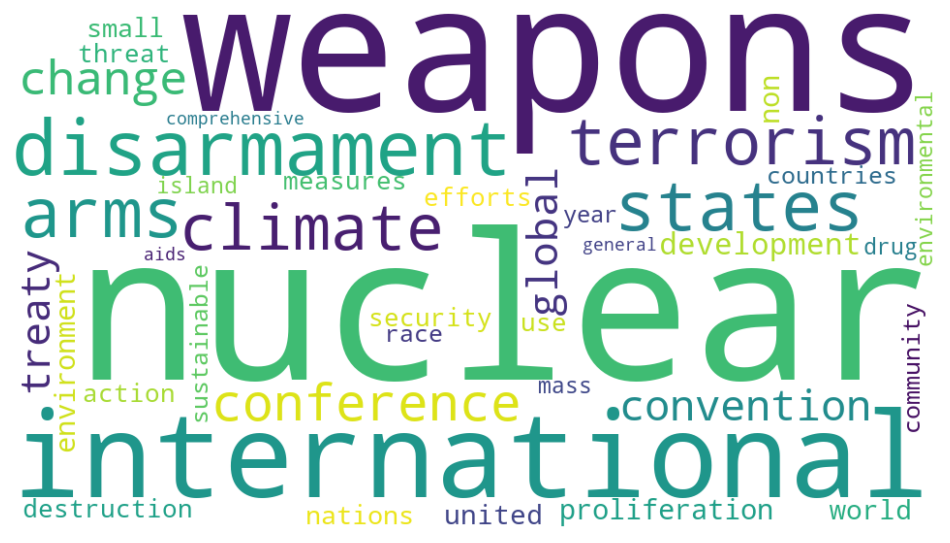

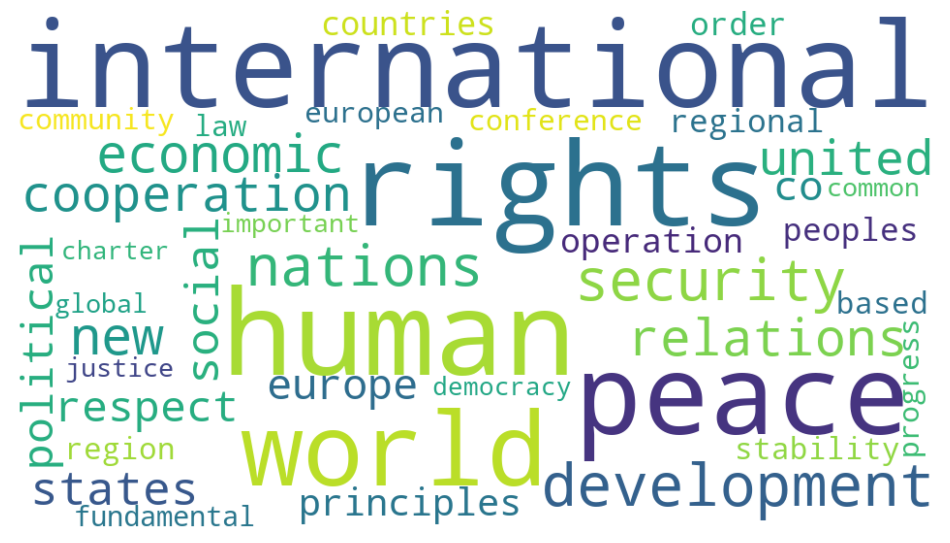

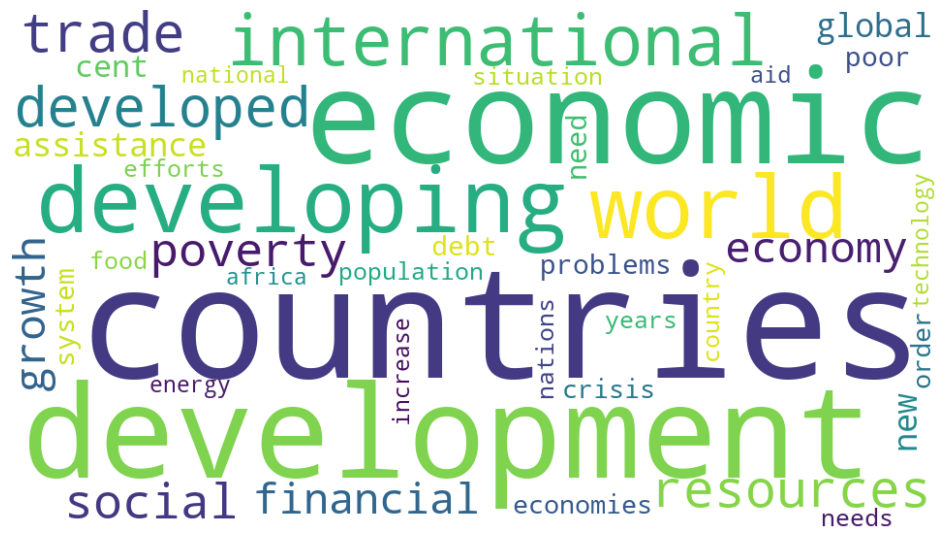

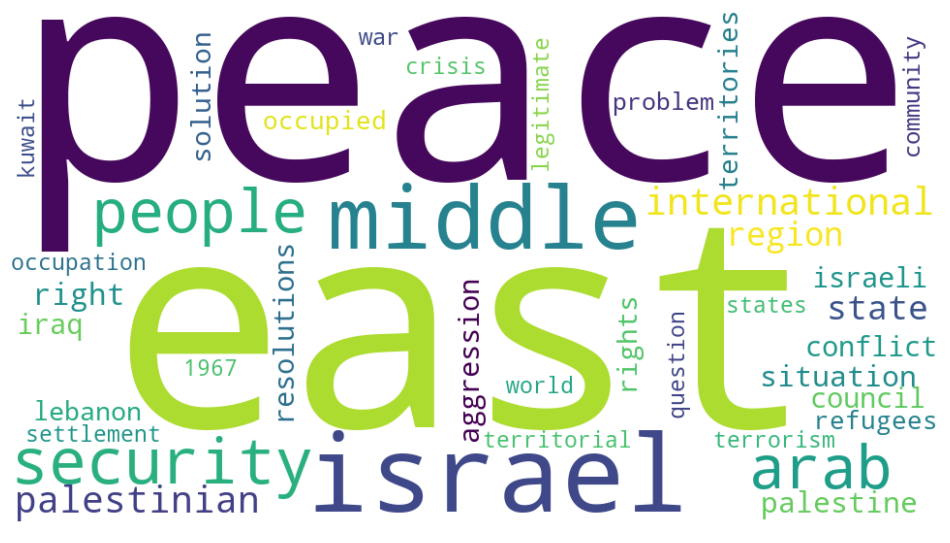

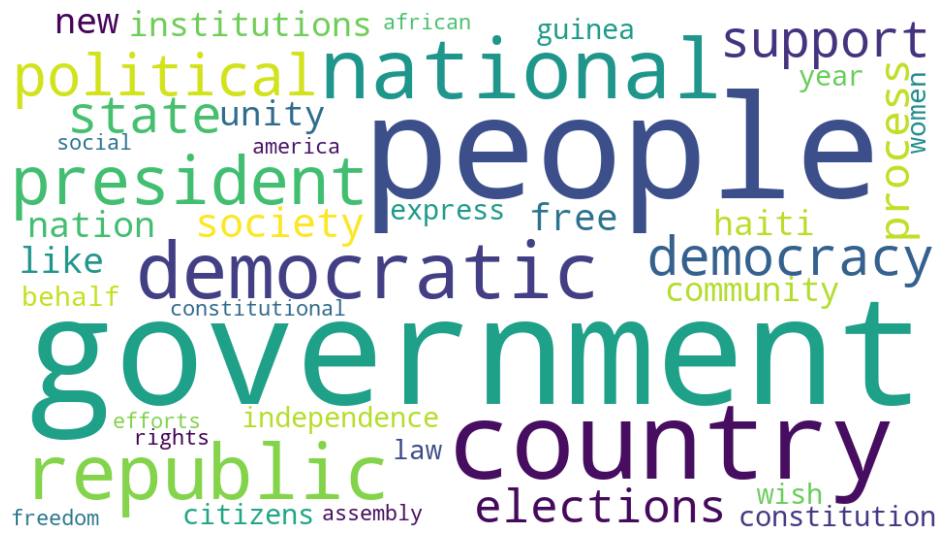

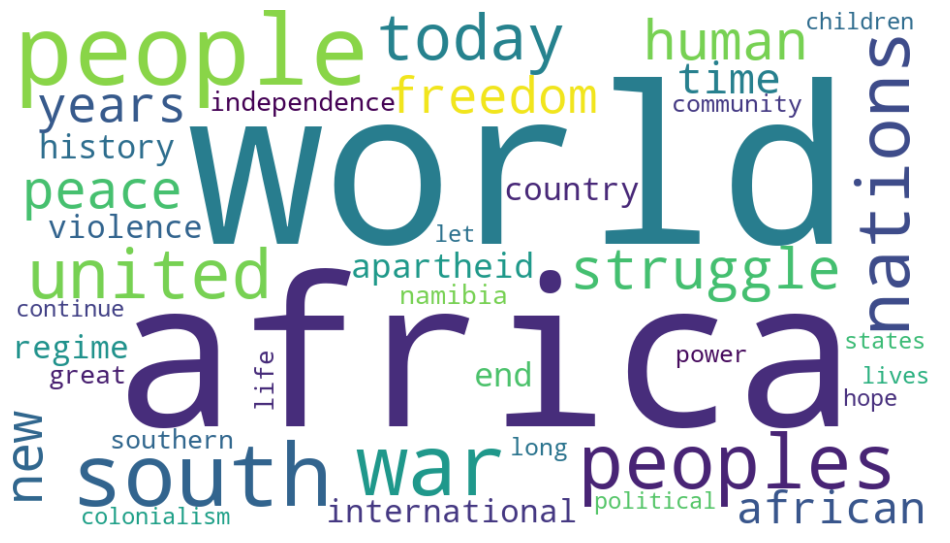

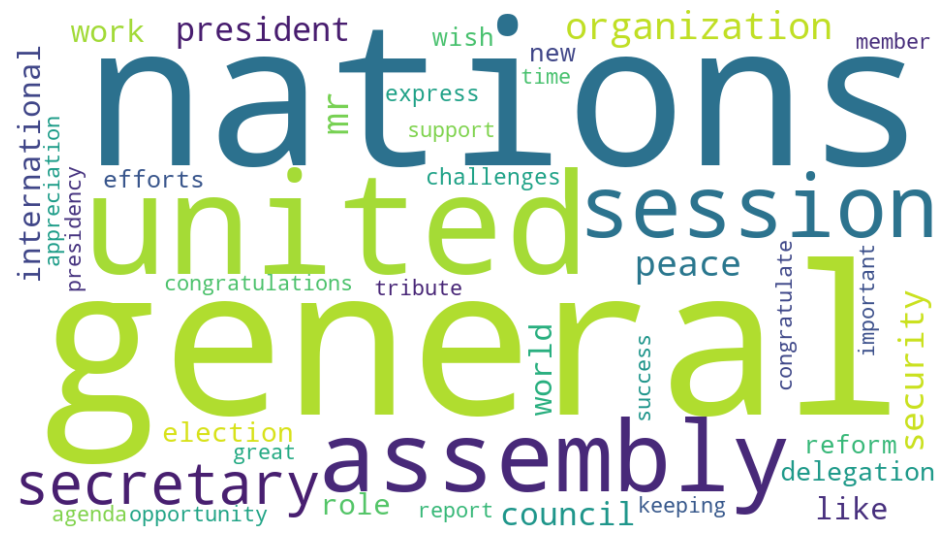

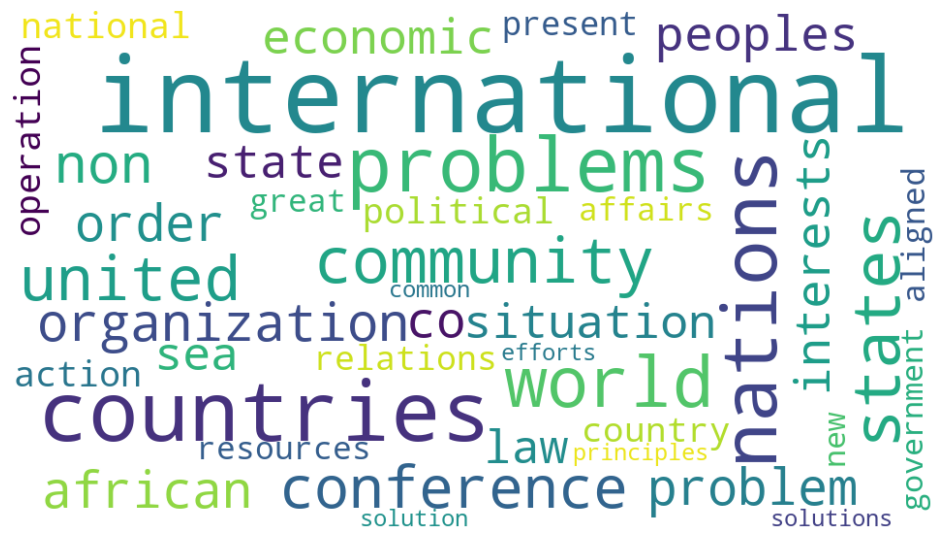

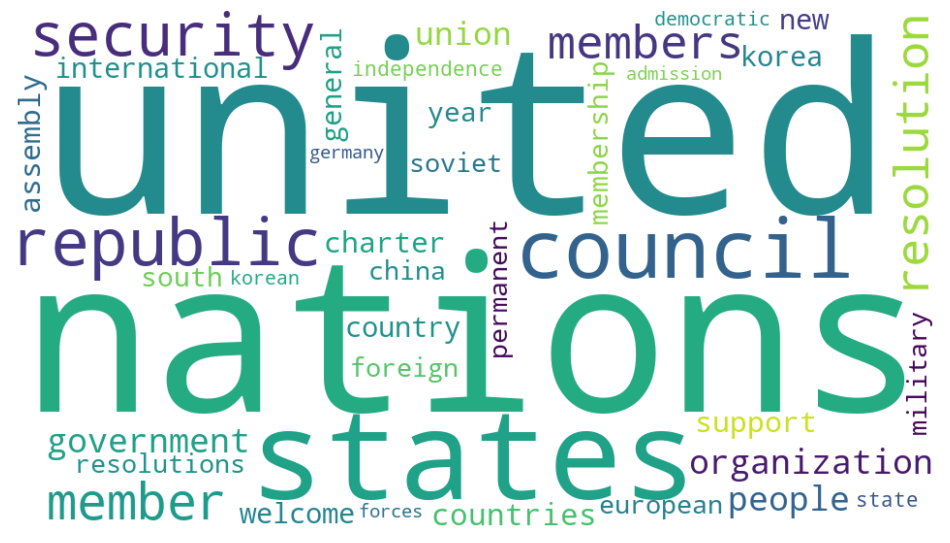

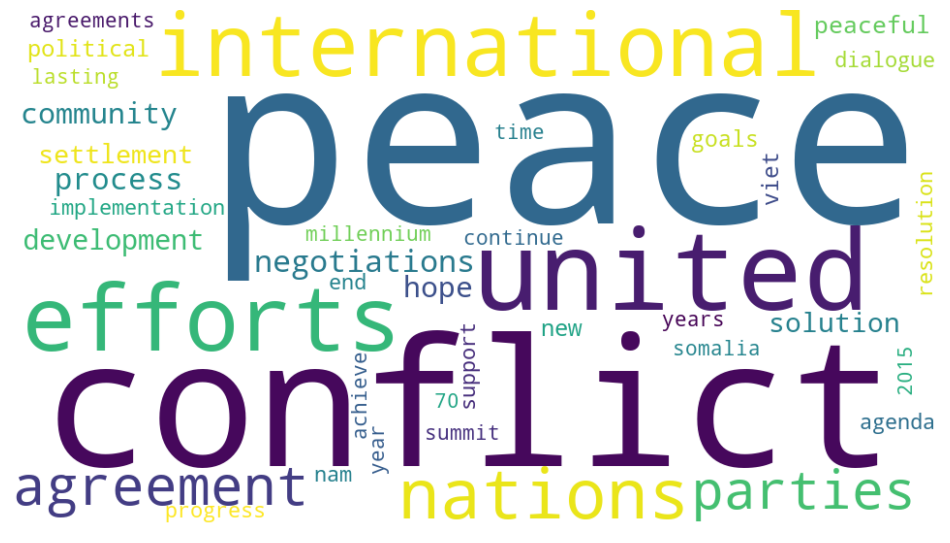

In [29]:
wordcloud_topics(lda_para_model, count_para_vectorizer.get_feature_names())

In [30]:
# create tokenized documents
gensim_paragraphs = [[w for w in re.findall(r'\b\w\w+\b' , paragraph.lower())
                          if w not in stopwords]
                             for paragraph in paragraph_df["text"]]

In [31]:
from gensim.corpora import Dictionary
dict_gensim_para = Dictionary(gensim_paragraphs)

In [32]:
dict_gensim_para.filter_extremes(no_below = 5, no_above = 0.7)

bow_gensim_para = [dict_gensim_para.doc2bow(paragraph) for paragraph in gensim_paragraphs]

In [33]:
from gensim.models import TfidfModel
tfidf_gensim_para = TfidfModel(bow_gensim_para)
vectors_gensim_para = tfidf_gensim_para[bow_gensim_para]

In [34]:
from gensim.models import LdaModel
lda_gensim_para = LdaModel(corpus = bow_gensim_para, id2word = dict_gensim_para,
    chunksize = 2000, alpha = 'auto', eta = 'auto', iterations = 400, num_topics = 10, 
    passes = 20, eval_every = None, random_state = 42)

In [35]:
def display_topics_gensim(model):
    for topic in range(0, model.num_topics):
        print("\nTopic %02d" % topic)
        for (word, prob) in model.show_topic(topic, topn=5):
            print("  %s (%2.2f)" % (word, prob))

In [36]:
display_topics_gensim(lda_gensim_para)


Topic 00
  peace (0.05)
  region (0.02)
  conflict (0.02)
  situation (0.01)
  stability (0.01)

Topic 01
  afghanistan (0.08)
  minister (0.03)
  afghan (0.03)
  al (0.03)
  round (0.02)

Topic 02
  countries (0.10)
  economic (0.04)
  developing (0.03)
  development (0.03)
  poverty (0.02)

Topic 03
  nations (0.09)
  united (0.09)
  security (0.04)
  states (0.04)
  council (0.03)

Topic 04
  general (0.09)
  assembly (0.07)
  session (0.04)
  secretary (0.04)
  president (0.03)

Topic 05
  people (0.04)
  country (0.03)
  government (0.03)
  human (0.03)
  rights (0.02)

Topic 06
  israel (0.04)
  palestinian (0.03)
  arab (0.03)
  lebanon (0.02)
  israeli (0.02)

Topic 07
  international (0.04)
  world (0.03)
  development (0.02)
  new (0.01)
  community (0.01)

Topic 08
  republic (0.02)
  year (0.02)
  years (0.02)
  relations (0.01)
  union (0.01)

Topic 09
  terrorism (0.10)
  weapons (0.03)
  nuclear (0.03)
  terrorist (0.02)
  convention (0.02)


In [37]:
from gensim.models.coherencemodel import CoherenceModel

lda_gensim_para_coherence = CoherenceModel(model = lda_gensim_para, texts = gensim_paragraphs, dictionary = dict_gensim_para, coherence = 'c_v')
lda_gensim_para_coherence_score = lda_gensim_para_coherence.get_coherence()
print(lda_gensim_para_coherence_score)

0.5875623314588496


In [38]:
top_topics = lda_gensim_para.top_topics(vectors_gensim_para, topn = 5)
avg_topic_coherence = sum([t[1] for t in top_topics]) / len(top_topics)
print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: -2.2659.


In [39]:
[(t[1], " ".join([w[1] for w in t[0]])) for t in top_topics]

[(-1.5032594031098014, 'nations united security states council'),
 (-1.5427691142570406, 'general assembly session secretary president'),
 (-1.6251176236379892, 'israel palestinian arab lebanon israeli'),
 (-1.626526854101956, 'international world development new community'),
 (-1.758293190749167, 'countries economic developing development poverty'),
 (-1.8885484643903787, 'people country government human rights'),
 (-2.3146986560590115, 'peace region conflict situation stability'),
 (-2.7260524208542347, 'republic year years relations union'),
 (-2.8276062340930483, 'terrorism weapons nuclear terrorist convention'),
 (-4.845644614192587, 'afghanistan minister afghan al round')]

In [40]:
from tqdm import tqdm

In [41]:
from gensim.models.ldamulticore import LdaMulticore
lda_para_model_n = []
for n in tqdm(range(5, 21)):
    lda_model = LdaMulticore(corpus = bow_gensim_para, id2word = dict_gensim_para,
                             chunksize = 2000, eta = 'auto', iterations = 400,
                             num_topics = n, passes = 20, eval_every = None,
                             random_state = 42)
    lda_coherence = CoherenceModel(model = lda_model, texts = gensim_paragraphs,
                                   dictionary = dict_gensim_para, coherence = 'c_v')
    lda_para_model_n.append((n, lda_model, lda_coherence.get_coherence()))

100%|██████████| 16/16 [6:14:09<00:00, 1403.08s/it]  


<Axes: xlabel='n'>

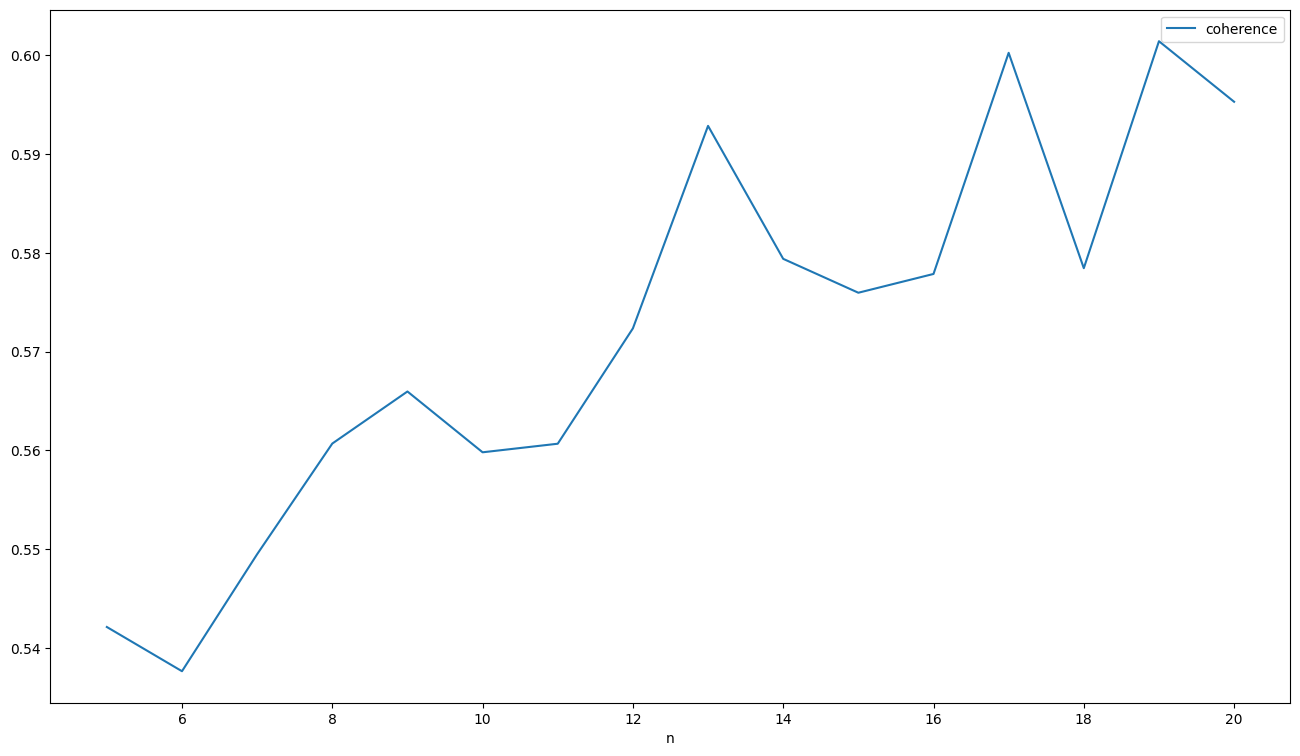

In [42]:
pd.DataFrame(lda_para_model_n, columns = ["n", "model", \
    "coherence"]).set_index("n")[["coherence"]].plot(figsize = (16,9))

In [43]:
display_topics_gensim(lda_para_model_n[12][1])


Topic 00
  international (0.03)
  peace (0.03)
  relations (0.01)
  principles (0.01)
  cooperation (0.01)

Topic 01
  israel (0.02)
  people (0.02)
  palestinian (0.02)
  right (0.01)
  peace (0.01)

Topic 02
  world (0.03)
  war (0.02)
  international (0.01)
  conflicts (0.01)
  problems (0.01)

Topic 03
  nations (0.09)
  united (0.09)
  organization (0.02)
  peace (0.02)
  international (0.02)

Topic 04
  terrorism (0.03)
  people (0.02)
  september (0.02)
  terrorist (0.02)
  11 (0.02)

Topic 05
  country (0.02)
  people (0.02)
  government (0.02)
  national (0.01)
  assistance (0.01)

Topic 06
  union (0.03)
  european (0.02)
  states (0.02)
  europe (0.02)
  sea (0.01)

Topic 07
  countries (0.04)
  economic (0.03)
  international (0.02)
  developing (0.02)
  development (0.02)

Topic 08
  world (0.02)
  new (0.02)
  future (0.01)
  year (0.01)
  years (0.01)

Topic 09
  terrorism (0.03)
  international (0.02)
  security (0.01)
  action (0.01)
  regional (0.01)

Topic 10
  coun